# Create an interactive window to refine masks in SAM

In [4]:
import time
import threading
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from ipywidgets import interact, IntSlider, HBox, VBox, Text, Button

sam_dir="/mmfs1/cm/shared/apps_local/sam2"
img_dir="/scratch/SDSMT.LOCAL/bscott/images"
cell_dir="/scratch/SDSMT.LOCAL/bscott/Cropped/ch0"
checkpoint = sam_dir+"/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
device = torch.device("cuda")
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [2]:
%matplotlib widget

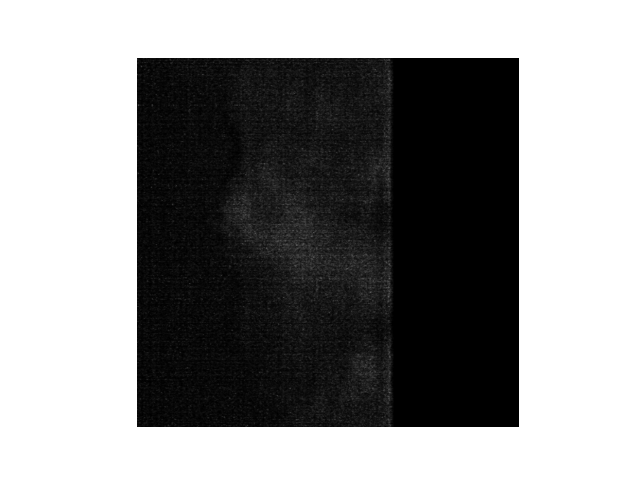

In [8]:
# Load the TIFF file
tiff_file = Image.open(cell_dir + '/cell2_CamB_ch0_stack0000_488nm_0000000msec_0014157451msecAbs_decon.tif')
num_pages = tiff_file.n_frames

# Dictionaries to store points for each page
pos_points_per_page = {i: [] for i in range(num_pages)}
neg_points_per_page = {i: [] for i in range(num_pages)}

# Continuous scroll state and speed
scrolling = False
animation_running = False  # State for animation
scroll_speed = 0.05  # Adjust this for faster/slower scrolling
animation_speed = 0.05  # Set interval for animated scrolling

# Placeholder functions for predictor and mask display (customize these as needed)
def show_masks(image, masks, scores, point_coords, input_labels):
    print(f"Displaying masks with scores: {scores}")

# Create figure and axes
fig, ax = plt.subplots()
img_display = ax.imshow(np.zeros((10, 10)), cmap="gray")  # Placeholder initial image
ax.axis('off')
current_page = 0  # Track the current page

# Event handler for mouse clicks
def on_click(event):
    input_label = np.array([1, 1])
    if event.inaxes == ax:
        x, y = int(event.xdata), int(event.ydata)

        if event.button == 1:  # Left-click for positive point
            pos_points_per_page[current_page].append((x, y))
            ax.plot(x, y, 'go')
            masks, scores, _ = predictor.predict(
                point_coords=pos_points_per_page[current_page],
                point_labels=input_label,
                mask_input=mask_input[None, :, :],
                multimask_output=False,
            )
            show_masks(image, masks, scores, point_coords=pos_points_per_page[current_page], input_labels=input_label)
        elif event.button == 3:  # Right-click for negative point
            neg_points_per_page[current_page].append((x, y))
            ax.plot(x, y, 'ro')

        fig.canvas.draw()

# Function to update the display to a specific page
def show_page(page_index):
    global current_page
    current_page = page_index

    tiff_file.seek(page_index)
    img_array = np.array(tiff_file)

    # Update the image display without opening a new figure
    ax.clear()
    ax.imshow(img_array, cmap="gray")
    ax.axis('off')

    # Draw markers for the current page
    for (x, y) in pos_points_per_page[page_index]:
        ax.plot(x, y, 'go')
    for (x, y) in neg_points_per_page[page_index]:
        ax.plot(x, y, 'ro')

    # Update the slider and text box
    page_slider.value = page_index
    page_text.value = str(page_index)

    fig.canvas.draw_idle()

# Continuous scrolling function
def continuous_scroll(direction):
    global scrolling
    scrolling = True
    while scrolling:
        if direction == 'next' and current_page < num_pages - 1:
            show_page(current_page + 1)
        elif direction == 'prev' and current_page > 0:
            show_page(current_page - 1)
        else:
            break
        time.sleep(scroll_speed)

# Start continuous scrolling on key press
def on_key_press(event):
    if event.key == 'n':  # Start scrolling forward
        threading.Thread(target=continuous_scroll, args=('next',)).start()
    elif event.key == 'p':  # Start scrolling backward
        threading.Thread(target=continuous_scroll, args=('prev',)).start()

# Stop scrolling on key release
def on_key_release(event):
    global scrolling
    if event.key in ('n', 'p'):
        scrolling = False

# Animation function to loop through pages
def animate_pages():
    global current_page, animation_running
    while animation_running:
        next_page = (current_page + 1) % num_pages
        show_page(next_page)
        time.sleep(animation_speed)

# Toggle animation on button click
def toggle_animation(button):
    global animation_running
    if animation_running:
        animation_running = False
        button.description = "Start Animation"
    else:
        animation_running = True
        button.description = "Stop Animation"
        threading.Thread(target=animate_pages).start()

# Interactive slider, text box, and animation button for page navigation
page_slider = IntSlider(value=0, min=0, max=num_pages - 1, step=1, description="Page:")
page_text = Text(value="0", description="Go to Page:")
animate_button = Button(description="Start Animation")

# Sync slider and text box
def on_slider_change(change):
    show_page(change.new)

def on_text_change(change):
    try:
        page_num = int(change['new'])
        if 0 <= page_num < num_pages:
            show_page(page_num)
    except ValueError:
        pass

# Connect event handlers
page_slider.observe(on_slider_change, names='value')
page_text.observe(on_text_change, names='value')
fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key_press)
fig.canvas.mpl_connect('key_release_event', on_key_release)
animate_button.on_click(toggle_animation)

# Layout for slider, text input, and animation button
controls = HBox([page_slider, page_text, animate_button])

# Display only the controls and the existing figure canvas
display(VBox([controls, fig.canvas]))

# Show initial page
show_page(0)
